In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
from random import randint
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_MITOSISi/Expression_CNA/Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
em_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_MITOSISi/Expression_Mutation/Predictions/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_MITOSISi/Expression_Mutation_CNA/Predictions/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_MITOSISi/Expression_CNA/Predictions/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_MITOSISi/Expression_CNA/Figures/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (MITOSISi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (MITOSISi)

GDSCE = pd.read_csv("GDSC_exprs.z.MITOSISi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
684055,1.3565140948247052,-0.277542411913307,0.0887087882196536,-0.2754829982302413,-0.5153856346587746,-0.6248712076433911,0.1243408990866293,-1.2699667684674136,2.0788360886382717,2.5197991997459197,...,-0.5571028630154293,-1.724090733574364,-0.3749080365068901,-0.0016055431935905,-0.3788535663547365,-1.3502092798315848,0.6949790577550328,0.4333032198982747,-0.1280986270308099,-1.629249958712223
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC CNA dataset (MITOSISi)

os.chdir(dataset_dir + "/CNA/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA


In [9]:
# read GDSC CNA dataset (MITOSISi)

GDSCC = pd.read_csv("GDSC_CNA.MITOSISi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCC.drop_duplicates(keep='last')
GDSCC = pd.DataFrame.transpose(GDSCC)
GDSCC = GDSCC.loc[:, ~GDSCC.columns.duplicated()]

GDSCC.head()

gene_id,1,2,9,10,12,13,14,15,16,18,...,107985535,107985759,107986588,107986809,107986898,107987337,107987341,109731405,112441434,121676927
683665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,1.807355,0.000000,0.000000,0.000000
684055,0.000000,0.584963,0.584963,0.584963,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.584963,0.000000,0.584963,0.584963,-4.32,-4.320000,0.000000,0.000000,0.584963
684057,-0.415037,0.000000,0.584963,0.584963,-1.000000,0.000000,0.0,0.0,-0.415037,-0.415037,...,-0.415037,0.000000,0.000000,0.000000,0.807355,-1.00,-1.000000,-0.415037,-0.415037,0.807355
684059,0.000000,0.000000,0.000000,0.000000,0.000000,0.415037,0.0,0.0,0.000000,0.415037,...,0.000000,0.000000,0.415037,0.000000,0.415037,-4.32,-4.320000,0.000000,0.000000,0.736966
684062,-0.415037,0.000000,0.321928,0.321928,-0.415037,-0.415037,0.0,0.0,-0.415037,0.000000,...,-0.415037,0.000000,0.000000,0.000000,0.321928,-4.32,-4.320000,-0.415037,-1.000000,0.321928


In [10]:
# change directory to read GDSC response dataset (MITOSISi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (MITOSISi)

GDSCR = pd.read_csv("GDSC_response.MITOSISi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR = GDSCR.loc[filter, ]
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,0.70402689461727,VX-680,1,1,1
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,0.307772732941787,S-Trityl-L-cysteine,1,1,1
683665,0,-1.86219201025588,BI-2536,1,1,1
683665,0,-3.03887798334128,GW843682X,1,1,1


In [12]:
# print count of cell lines for each drug (MITOSISi)

GDSCR["drug"].value_counts()

drug
Genentech Cpd 10       771
SB-715992              770
NPK76-II-72-1          769
MPS-1-IN-1             767
GSK1070916             747
ZM-447439              694
Paclitaxel             370
GW843682X              370
S-Trityl-L-cysteine    369
BI-2536                368
VX-680                 365
Name: count, dtype: int64

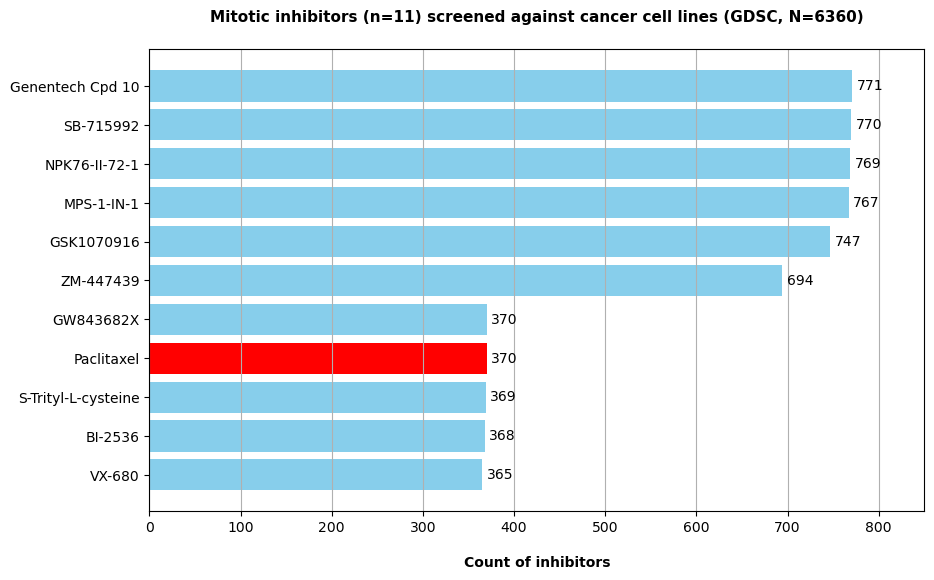

In [13]:
# plot mitotic inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Paclitaxel":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'Mitotic inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'Mitotic Inhibitors with Their Counts (GDSC, Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read PDX expression dataset homogenized with GDSC expression dataset (Paclitaxel)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (Paclitaxel)

PDXEpaclitaxel = pd.read_csv("PDX_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEpaclitaxel = pd.DataFrame.transpose(PDXEpaclitaxel)
PDXEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1008,5.1683455924601,6.40148605928778,5.14735257900894,2.62182669498089,5.65801642244848,2.56126582112594,7.9002150761815,2.99037104024989,9.07138836072349,2.93107188443328,...,2.51273514040916,3.16885840754458,7.88710414124411,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,3.95569877310649,3.86826539821721,2.24540260166309
X-1156,5.64285976724198,6.16403060339034,6.56682953977831,2.62182669498089,2.20555612143949,2.68000643826337,8.28747895280708,2.40648953950849,6.85807798266578,3.44682372154383,...,2.6201404525098,3.05224139425924,6.43259864910441,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,5.32315076936616,3.85690425090814,2.27121625384186
X-1172,2.76326591576383,6.63737682195879,5.67675838505579,2.79473965144091,3.52596051559272,5.74258764261314,8.70184553811941,2.66283398075993,9.95397018105127,3.64884172474159,...,2.68566229198938,3.11779249946595,5.44497097056128,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,2.45399733779172,4.19271392722119,2.21127349569176


In [16]:
# change directory to read PDX CNA dataset (Paclitaxel)

os.chdir(dataset_dir + "CNA")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA'

In [17]:
# read PDX CNA dataset (Paclitaxel)

PDXCpaclitaxel = pd.read_csv("PDX_CNA.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXCpaclitaxel.drop_duplicates(keep='last')
PDXCpaclitaxel = pd.DataFrame.transpose(PDXCpaclitaxel)
PDXCpaclitaxel = PDXCpaclitaxel.loc[:, ~PDXCpaclitaxel.columns.duplicated()]

PDXCpaclitaxel.head(3)

ENTREZID,1,2,3,9,10,12,13,14,15,16,...,101340252,102723547,102724473,103091865,105375355,107126285,109623460,109731405,118126072,128385369
X-1008,-0.3219280948873623,0.0,0.0,-1.6896598793878497,-1.6896598793878497,0.0,0.6182386555954547,-0.5145731728297583,0.0,-0.3400754415976217,...,0.3276873641760471,-0.3219280948873623,0.3785116232537298,0.0,-0.3129393116601076,0.0,-1.888968687611256,-0.3400754415976217,-0.7369655941662062,0.0
X-1156,0.9781956296816516,0.7004397181410922,0.7004397181410922,-0.2429767534925404,-0.2429767534925404,-0.2863041851566411,0.5607149544744789,0.3895668117627256,-0.2688167584278,-0.2688167584278,...,0.4594316186372972,0.0,-0.4246876693125631,-0.7369655941662062,0.0,1.100977647724821,-0.3770696490798233,-0.3219280948873623,-0.6551715030025588,0.0
X-1172,0.0,0.0,0.0,-0.5145731728297583,-0.5145731728297583,0.0,0.4276061727818994,0.4222330006830478,0.9297909977185974,0.0,...,-0.5994620704162712,-0.6780719051126377,0.3895668117627256,-0.4639470997597902,0.859969548221026,0.5109619192773793,-0.2863041851566411,0.0,0.0,1.0214797274104517


In [18]:
# variance threshold for GDSC expression dataset (MITOSISi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [19]:
# fill NA values and binarize GDSC CNA dataset (MITOSISi)

GDSCC = GDSCC.fillna(0)
GDSCC[GDSCC != 0.0] = 1

In [20]:
# select shared genes between GDSC and PDX expression and CNA datasets 

ls = GDSCE.columns.intersection(GDSCC.columns)
ls = ls.intersection(PDXEpaclitaxel.columns)
ls = ls.intersection(PDXCpaclitaxel.columns)

ls = pd.unique(ls)

print(f"GDSC and PDX # of common genes: {ls.shape[0]}")

GDSC and PDX # of common genes: 17901


In [21]:
# select shared samples between GDSC expression and response datasets (MITOSISi)

ls2 = GDSCE.index.intersection(GDSCC.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 799


In [22]:
# subset shared genes and samples in GDSC expression, CNA, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCC = GDSCC.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCC.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (799, 17901)
GDSC # of common samples and genes (CNA): (799, 17901)
GDSC # of samples (Response): 6360


In [23]:
# select shared samples between PDX expression and CNA datasets (Paclitaxel) 

ls3 = PDXEpaclitaxel.index.intersection(PDXCpaclitaxel.index)

print(f"PDX # of common samples (Paclitaxel): {ls3.shape[0]}")

PDX # of common samples (Paclitaxel): 43


In [24]:
# select shared genes and samples between PDX expression and CNA datasets (Paclitaxel)

PDXEpaclitaxel = PDXEpaclitaxel.loc[ls3, ls]
PDXCpaclitaxel = PDXCpaclitaxel.loc[ls3, ls]

print(f"PDX # of common samples and genes for Expression (Paclitaxel): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for CNA (Paclitaxel): {PDXCpaclitaxel.shape}\n")

PDX # of common samples and genes for Expression (Paclitaxel): (43, 17901)
PDX # of common samples and genes for CNA (Paclitaxel): (43, 17901)



In [25]:
# change directory to read DEGs (MITOSISi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/MITOSISi


In [26]:
# read DEGs (MITOSISi)

DEGs_filtered_data = pd.read_excel("MITOSISi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among mitotic inhibitors\n")

DEGs_filtered_data.head()

There are 996 DEGs (p-adjusted < 0.05 and |logFC| > 1) among mitotic inhibitors



,Gene Symbol,Frequency
0,PLS3,8
1,GMFG,7
2,GPRC5A,7
3,TJP1,7
4,CXCR4,7


In [27]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CAST', 2), ('CLECL1P', 2)]
1 input query terms found no hit:	['SLC22A18']


996

In [28]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
cna = GDSCC
responses = GDSCR

In [29]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,0.70402689461727,VX-680,1,1,1
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,0.307772732941787,S-Trityl-L-cysteine,1,1,1


In [30]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'BI-2536',
 'GSK1070916',
 'GW843682X',
 'Genentech Cpd 10',
 'MPS-1-IN-1',
 'NPK76-II-72-1',
 'Paclitaxel',
 'S-Trityl-L-cysteine',
 'SB-715992',
 'VX-680',
 'ZM-447439'}

In [31]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([ 683665,  683665,  683665,  683665,  683665,  683665,  683665,  683665,
        683665,  683665,
       ...
        949167,  998184, 1290771, 1298156, 1330948, 1330993, 1503364, 1509073,
       1659818, 1659819],
      dtype='int64', length=6360)

In [32]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
dat.head()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,,,,,,,,,,,,,
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,2.2784384580266,VX-680,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,-4.02193345692394,Paclitaxel,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,1.3890399069148,S-Trityl-L-cysteine,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,-2.63409751556526,BI-2536,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,-2.82633771115996,GW843682X,1,1,1


In [33]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    433
glioma                       383
lung_NSCLC_adenocarcinoma    371
melanoma                     343
breast                       311
Name: count, dtype: int64

In [34]:
# get count of total BRCA and NSCLC tissues

tissues = dat["GDSC\nTissue\ndescriptor 2"].value_counts()
count_selected_tissues = tissues["breast"].astype(int) + \
                         tissues["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues["lung_NSCLC_large cell"].astype(int) + \
                         tissues["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues["lung_NSCLC_not specified"].astype(int) + \
                         tissues["lung_NSCLC_carcinoid"].astype(int) 
count_selected_tissues

911

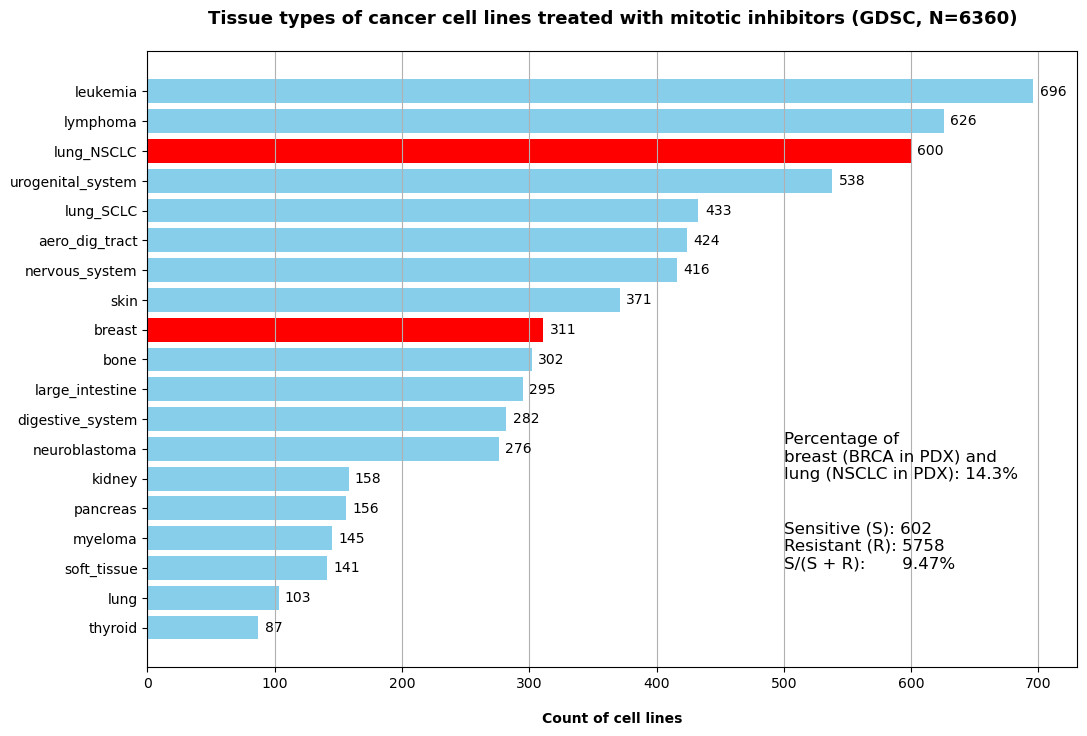

In [35]:
# plot tissue types of cancer cell lines treated with mitotic inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with mitotic inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "breast" or name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(500, 13, 
         f'Percentage of \nbreast (BRCA in PDX) and \nlung (NSCLC in PDX): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(500, 16, 
         f'Sensitive (S): {dat[["response"]].value_counts()[1]} \nResistant (R): {dat[["response"]].value_counts()[0]} \nS/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')


plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with mitotic inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [36]:
# list count of cell lines as to tissues treated with paclitaxel

filter = (dat["drug"] == "Paclitaxel")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
leukemia             64
lymphoma             57
lung_SCLC            35
nervous_system       25
neuroblastoma        23
lung_NSCLC           20
bone                 20
skin                 19
urogenital_system    16
large_intestine      15
aero_dig_tract       14
myeloma              13
digestive_system     12
breast               11
kidney               10
soft_tissue           9
lung                  3
pancreas              2
thyroid               2
Name: count, dtype: int64

In [37]:
# list count of cell lines as to tissues treated with paclitaxel

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Paclitaxel")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    35
acute_myeloid_leukaemia      25
neuroblastoma                23
B_cell_lymphoma              23
glioma                       23
Name: count, dtype: int64

In [38]:
# count of BRCA and NSCLC cell lines treated with paclitaxel

count_selected_tissues = tissues_drug["breast"].astype(int) + \
                         tissues_drug["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues_drug["lung_NSCLC_large cell"].astype(int) + \
                         tissues_drug["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues_drug["lung_NSCLC_not specified"].astype(int) + \
                         tissues_drug["lung_NSCLC_carcinoid"].astype(int) 

count_selected_tissues

31

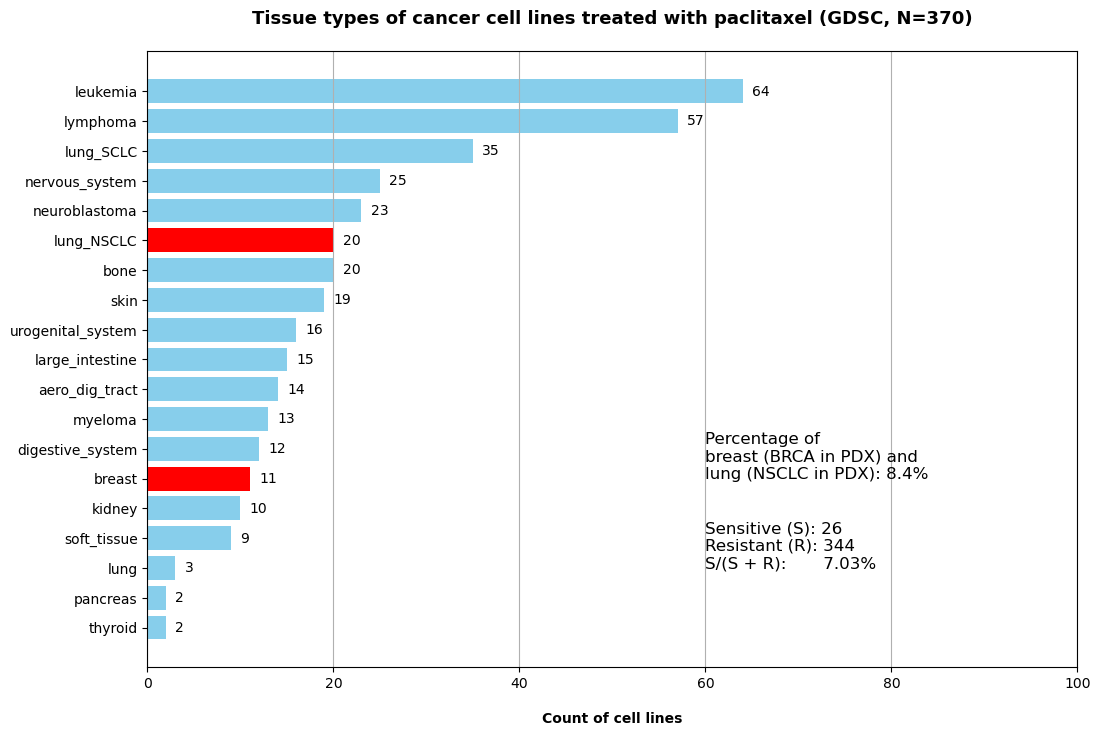

In [39]:
# plot tissue types of cancer cell lines treated with paclitaxel

gdsc_tissue_counts =  tissues_drugs.loc[filter, 'GDSC\nTissue descriptor 1'].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with paclitaxel (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.xlim(0, 100)
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "breast" or name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(60, 13, 
         f'Percentage of \nbreast (BRCA in PDX) and \nlung (NSCLC in PDX): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(60, 16, 
         f'Sensitive (S): {dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[1]} \nResistant (R): {dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[0]} \nS/(S + R):       {round(dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[1]/(sum(dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with paclitaxel (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [40]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '949167', '998184', '1290771', '1298156', '1330948', '1330993',
       '1503364', '1509073', '1659818', '1659819'],
      dtype='object', length=6360)

In [41]:
# filter GDSC expression and CNA datasets (MITOSISi) as to drugs
# subset selected DEGs

expression_zscores = []
CNA = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    expression_zscores.append(e_z)
    CNA.append(c)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls4 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls5 = GDSCEv2.index.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls5, ls4]
GDSCCv2 = GDSCCv2.loc[ls5, ls4]
GDSCRv2 = GDSCRv2.loc[ls5, :]

PDXEpaclitaxel = PDXEpaclitaxel.loc[:,ls4]
PDXCpaclitaxel = PDXCpaclitaxel.loc[:,ls4]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Paclitaxel (Expression): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Paclitaxel (CNA): {PDXCpaclitaxel.shape}\n")

GDSC # of common samples and genes (Expression): (6360, 986)
GDSC # of common samples and genes (CNA): (6360, 986)
GDSC # of common samples (Response): 6360

PDX # of common samples and genes for Paclitaxel (Expression): (43, 986)
PDX # of common samples and genes for Paclitaxel (CNA): (43, 986)



In [42]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 0 1]


In [43]:
# change directory to read PDX response dataset (Paclitaxel)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [44]:
# read PDX response dataset (Paclitaxel)

PDXRpaclitaxel = pd.read_csv("PDX_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRpaclitaxel.dropna(inplace=True)
PDXRpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRpaclitaxel["response"] = PDXRpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel = PDXRpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel.shape[0]} samples with response data in the PDX (Paclitaxel)\n")
Ytspaclitaxel

There are 43 samples with response data in the PDX (Paclitaxel)



array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [45]:
# read PDX dataset to select cohorts (Paclitaxel)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "paclitaxel",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-1004,BRCA
X-1008,BRCA
X-1156,NSCLC
X-1172,NSCLC
X-1189,NSCLC


In [46]:
# merged PDX cohort table with PDX response dataset (Paclitaxel)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRpaclitaxel,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
BRCA     24
NSCLC    19
Name: count, dtype: int64

In [47]:
# filter BRCA cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "BRCA")
pdx_brca_samples = dat_pdx.loc[filter,].index
pdx_brca_samples

Index(['X-1008', 'X-1298', 'X-1371', 'X-1383', 'X-1407', 'X-1468', 'X-1600',
       'X-1916', 'X-1921', 'X-2195', 'X-2344', 'X-2487', 'X-2524', 'X-2780',
       'X-3298', 'X-3450', 'X-3873', 'X-4347', 'X-4567', 'X-4824', 'X-4949',
       'X-5502', 'X-5975', 'X-6047'],
      dtype='object')

In [48]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_brca = PDXRpaclitaxel.loc[pdx_brca_samples,"response"].values
Ytspaclitaxel_brca

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0])

In [49]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

PDXRpaclitaxel.loc[pdx_brca_samples,"response"].value_counts()

response
0    19
1     5
Name: count, dtype: int64

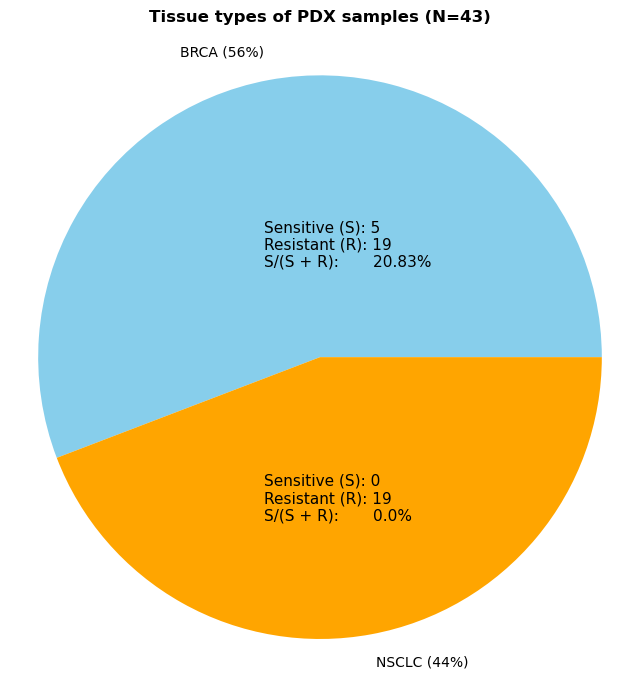

In [50]:
# plot tissue types of PDX samples 

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue','orange'])
plt.title(f'Tissue types of PDX samples (N={total})', fontweight = "bold", pad = 20)
plt.axis('equal')  

plt.text(-0.2, 0.4, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts())) * 100, 2)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.text(-0.2, -0.5, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1,0)} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1,0)/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts())) * 100, 2)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [51]:
# filter NSCLC cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1787',
       'X-1823', 'X-1834', 'X-1835', 'X-1934', 'X-1980', 'X-1993', 'X-2017',
       'X-2042', 'X-2082', 'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [52]:
# filter responses of NSCLC cohort samples (Paclitaxel)

Ytspaclitaxel_nsclc = PDXRpaclitaxel.loc[pdx_nsclc_samples,"response"].values
Ytspaclitaxel_nsclc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [53]:
# define maximum iteration

max_iter = 50

In [54]:
# assign number of neurons and dropout rates found for layers from the saved models

hdm1 = 512
hdm2 = 128
rate1 = 0.6
rate2 = 0.6
rate3 = 0.7

In [55]:
# load pre-trained models and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEpaclitaxel = scalerGDSC.transform(PDXEpaclitaxel.values)    
X_testEpaclitaxel_brca = scalerGDSC.transform(PDXEpaclitaxel.loc[pdx_brca_samples,].values)  

X_trainC = np.nan_to_num(GDSCCv2.values)
X_testCpaclitaxel = np.nan_to_num(PDXCpaclitaxel.values.astype(np.float32))
X_testCpaclitaxel_brca = np.nan_to_num(PDXCpaclitaxel.loc[pdx_brca_samples,].values.astype(np.float32))

TX_testEpaclitaxel = torch.FloatTensor(X_testEpaclitaxel)
TX_testEpaclitaxel_brca = torch.FloatTensor(X_testEpaclitaxel_brca)

TX_testCpaclitaxel = torch.FloatTensor(X_testCpaclitaxel.astype(np.float32))
TX_testCpaclitaxel_brca = torch.FloatTensor(X_testCpaclitaxel_brca.astype(np.float32))

ty_testEpaclitaxel = torch.FloatTensor(Ytspaclitaxel.astype(int))
ty_testEpaclitaxel_brca = torch.FloatTensor(Ytspaclitaxel_brca.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampC, IC_dim = X_trainC.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2 

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        self.EnC = torch.nn.Sequential(
            nn.Linear(IC_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnC(x)
        return output       

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA.pt")
AutoencoderC = torch.load(models_dir + "CNA_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA.pt")
Clas = torch.load(models_dir + "Class_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA.pt")

AutoencoderE.eval()
AutoencoderC.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZCX = AutoencoderC(torch.FloatTensor(X_trainC))
ZTX = torch.cat((ZEX, ZCX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (MITOSISi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (MITOSISi): {round(AUCTaucpr,2)}")

ZETpaclitaxel = AutoencoderE(TX_testEpaclitaxel)
ZCTpaclitaxel = AutoencoderC(TX_testCpaclitaxel)
ZTTpaclitaxel = torch.cat((ZETpaclitaxel, ZCTpaclitaxel), 1)
ZTTpaclitaxel = F.normalize(ZTTpaclitaxel, p=2, dim=0)
PredTpaclitaxel = Clas(ZTTpaclitaxel)
AUCTpaclitaxel = roc_auc_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
#print(f"PDX - Test AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}")
AUCTpaclitaxel_aucpr = average_precision_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
#print(f"PDX - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}")

ZETpaclitaxel_brca = AutoencoderE(TX_testEpaclitaxel_brca)
ZCTpaclitaxel_brca = AutoencoderC(TX_testCpaclitaxel_brca)
ZTTpaclitaxel_brca = torch.cat((ZETpaclitaxel_brca, ZCTpaclitaxel_brca), 1)
ZTTpaclitaxel_brca = F.normalize(ZTTpaclitaxel_brca, p=2, dim=0)
PredTpaclitaxel_brca = Clas(ZTTpaclitaxel_brca)
AUCTpaclitaxel_brca = roc_auc_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
#print(f"PDX - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca,2)}")
AUCTpaclitaxel_brca_aucpr = average_precision_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
#print(f"PDX - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca_aucpr,2)}\n")

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTpaclitaxel_finetuned = dict()
AUCTpaclitaxel_brca_finetuned = dict()
AUCTpaclitaxel_aucpr_finetuned = dict()
AUCTpaclitaxel_brca_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(models_dir + f"Finetuned_Models/Exprs_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{iter}.pt")
   AutoencoderC_finetuned = torch.load(models_dir + f"Finetuned_Models/CNA_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(models_dir + f"Finetuned_Models/Class_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderC_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZCX = AutoencoderC_finetuned(torch.FloatTensor(X_trainC))
   ZTX = torch.cat((ZEX, ZCX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETpaclitaxel = AutoencoderE_finetuned(TX_testEpaclitaxel)
   ZCTpaclitaxel = AutoencoderC_finetuned(TX_testCpaclitaxel)
   ZTTpaclitaxel = torch.cat((ZETpaclitaxel, ZCTpaclitaxel), 1)
   ZTTpaclitaxel = F.normalize(ZTTpaclitaxel, p=2, dim=0)
   PredTpaclitaxel = Clas_finetuned(ZTTpaclitaxel)
   AUCTpaclitaxel_finetuned[iter] = roc_auc_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
   AUCTpaclitaxel_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())

   ZETpaclitaxel_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_brca)
   ZCTpaclitaxel_brca = AutoencoderC_finetuned(TX_testCpaclitaxel_brca)
   ZTTpaclitaxel_brca = torch.cat((ZETpaclitaxel_brca, ZCTpaclitaxel_brca), 1)
   ZTTpaclitaxel_brca = F.normalize(ZTTpaclitaxel_brca, p=2, dim=0)
   PredTpaclitaxel_brca = Clas_finetuned(ZTTpaclitaxel_brca)
   AUCTpaclitaxel_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
   AUCTpaclitaxel_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())

max_key = max(AUCTpaclitaxel_aucpr_finetuned, key=AUCTpaclitaxel_aucpr_finetuned.get)
max_key_brca = max(AUCTpaclitaxel_brca_aucpr_finetuned, key=AUCTpaclitaxel_brca_aucpr_finetuned.get)

print(f"GDSC - Training AUC (MITOSISi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (MITOSISi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}")
print(f"PDX - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca,2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca_aucpr,2)}\n")

print(f"GDSC - Training AUC (MITOSISi, Finetuned): {round(AUCT_finetuned[max_key],2)}")
print(f"GDSC - Training AUCPR (MITOSISi, Finetuned): {round(AUCTaucpr_finetuned[max_key],2)}")
print(f"PDX - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_finetuned[max_key],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_aucpr_finetuned[max_key],2)}\n")

print(f"GDSC - Training AUC (MITOSISi, Finetuned): {round(AUCT_finetuned[max_key_brca],2)}")
print(f"GDSC - Training AUCPR (MITOSISi, Finetuned): {round(AUCTaucpr_finetuned[max_key_brca],2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_brca_finetuned[max_key_brca],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_brca_aucpr_finetuned[max_key_brca],2)}\n\n")

print("Models for maximum finetuning (Paclitaxel)")
print(f"Exprs_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{max_key}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{max_key}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{max_key}.pt")

print("\nModels for maximum finetuning (Paclitaxel, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{max_key_brca}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{max_key_brca}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_{max_key_brca}.pt")

GDSC - Training AUC (MITOSISi): 0.77
GDSC - Training AUCPR (MITOSISi): 0.27
PDX - Test AUC (Paclitaxel): 0.67
PDX - Test AUCPR (Paclitaxel): 0.22
PDX - Test AUC (Paclitaxel, BRCA): 0.56
PDX - Test AUCPR (Paclitaxel, BRCA): 0.27

GDSC - Training AUC (MITOSISi, Finetuned): 0.81
GDSC - Training AUCPR (MITOSISi, Finetuned): 0.32
PDX - Test AUC (Paclitaxel, Finetuned): 0.88
PDX - Test AUCPR (Paclitaxel, Finetuned): 0.44

GDSC - Training AUC (MITOSISi, Finetuned): 0.81
GDSC - Training AUCPR (MITOSISi, Finetuned): 0.32
PDX - Test AUC (Paclitaxel, BRCA, Finetuned): 0.87
PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): 0.67


Models for maximum finetuning (Paclitaxel)
Exprs_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_15.pt
CNA_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_15.pt
Class_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_15.pt

Models for maximum finetuning (Paclitaxel, BRCA)
Exprs_Paclitaxel_GDSC_PDX_MITOSISi_Expression_CNA_Finetuned_15.pt
CNA_Paclitaxel_GDSC_P

In [56]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=986, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [57]:
# show CNA layer parameters

AutoencoderC

AEC(
  (EnC): Sequential(
    (0): Linear(in_features=986, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [58]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=640, out_features=1, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Sigmoid()
  )
)

In [59]:
# create a dataframe with the prediction results 

ec = {"Data": ["Expr + CNA", "Expr + CNA (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key],2)],
       "AUC (PDX)": [round(AUCTpaclitaxel,2), round(AUCTpaclitaxel_finetuned[max_key],2)],
       "AUCPR (PDX)":  [round(AUCTpaclitaxel_aucpr,2), round(AUCTpaclitaxel_aucpr_finetuned[max_key],2)],
       "AUC (PDX-BRCA)":  [round(AUCTpaclitaxel_brca,2), round(AUCTpaclitaxel_brca_finetuned[max_key_brca],2)],
       "AUCPR (PDX-BRCA)": [round(AUCTpaclitaxel_brca_aucpr,2), round(AUCTpaclitaxel_brca_aucpr_finetuned[max_key_brca],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}
ec_dataframe = pd.DataFrame.from_dict(ec, orient='index').transpose()  
ec_dataframe.to_csv(save_results_to + "GDSC_PDX_Expression_CNA_MITOSISi_Paclitaxel.tsv",
                    sep = "\t",
                    index = False)

ec_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytspaclitaxel)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytspaclitaxel)) + ")",
    "AUC (PDX-BRCA)": "AUC (PDX-BRCA, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int)))) + ")",
    "AUCPR (PDX-BRCA)": "AUCPR (PDX-BRCA, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int)))) + ")",
    }, inplace = True
)

ec_dataframe

,Data,"AUC (GDSC, N=6360)","AUCPR (GDSC, N=6360)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + CNA,0.77,0.27,0.67,0.22,0.56,0.27,6360,986
1,Expr + CNA (Fine-tuned),0.81,0.32,0.88,0.44,0.87,0.67,6360,986


In [61]:
# merge all EM, EC, and EMC dataframes 

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_Expression_Mutation_CNA_MITOSISi_Paclitaxel.tsv",
                           sep = "\t")
emc_dataframe.columns = ec_dataframe.columns

em_dataframe = pd.read_csv(em_dir + "GDSC_PDX_Expression_Mutation_MITOSISi_Paclitaxel.tsv",
                           sep = "\t")
em_dataframe.columns = ec_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=6360)","AUCPR (GDSC, N=6360)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,
Expr + Mut + CNA,0.84,0.39,0.64,0.19,0.59,0.42,6360,847
Expr + Mut + CNA (Fine-tuned),0.85,0.41,0.76,0.42,0.75,0.58,6360,847
Expr + CNA,0.77,0.27,0.67,0.22,0.56,0.27,6360,986
Expr + CNA (Fine-tuned),0.81,0.32,0.88,0.44,0.87,0.67,6360,986
Expr + Mut,0.83,0.37,0.38,0.11,0.32,0.18,6360,848
Expr + Mut (Fine-tuned),0.85,0.39,0.53,0.15,0.49,0.25,6360,848


In [62]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytspaclitaxel))})",
                               f"AUC (PDX-BRCA, N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytspaclitaxel))})": f"PDX (N={str(len(Ytspaclitaxel))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-BRCA, N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))})": f"PDX-BRCA (N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
    }, inplace = True
)
auc_dataframe

,"GDSC (N=6360, p=986\nS=602, R=5758, S/N=0.09)","PDX (N=43, p=986\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=986\nS=5, R=19, S/N=0.21)"
Data,,,
Expr + Mut + CNA,0.84,0.64,0.59
Expr + Mut + CNA (Fine-tuned),0.85,0.76,0.75
Expr + CNA,0.77,0.67,0.56
Expr + CNA (Fine-tuned),0.81,0.88,0.87
Expr + Mut,0.83,0.38,0.32
Expr + Mut (Fine-tuned),0.85,0.53,0.49


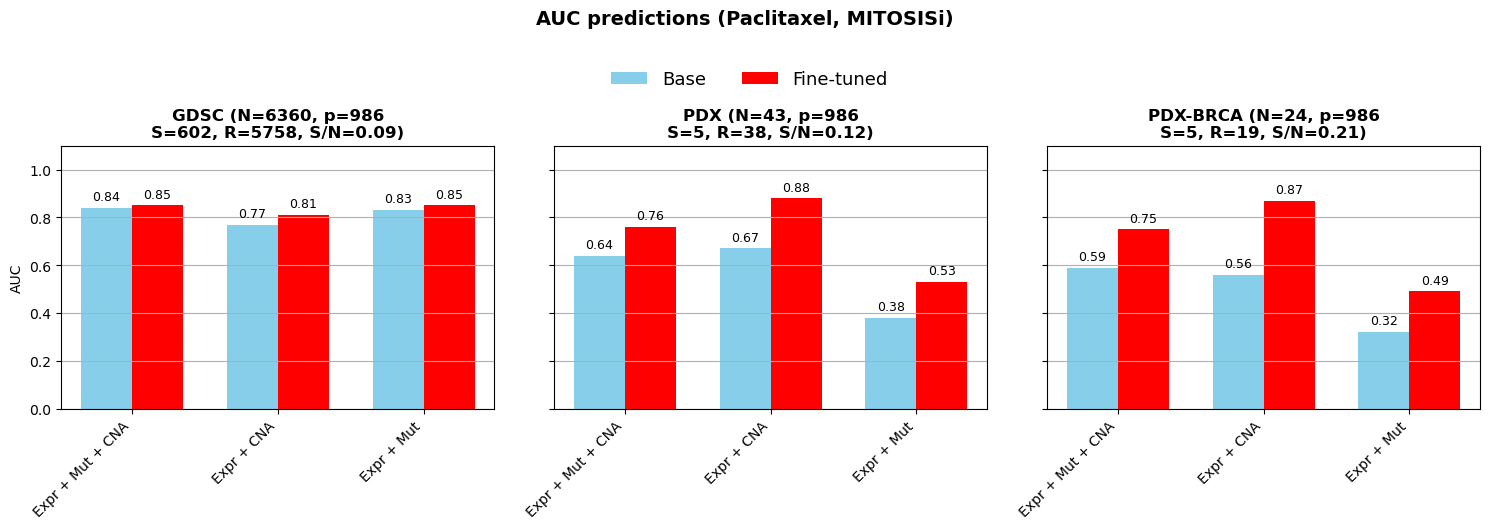

In [64]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Paclitaxel, MITOSISi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Paclitaxel, MITOSISi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [65]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (PDX, N={str(len(Ytspaclitaxel))})",
                                 f"AUCPR (PDX-BRCA, N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytspaclitaxel))})": f"PDX (N={str(len(Ytspaclitaxel))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-BRCA, N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))})": f"PDX-BRCA (N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=6360, p=986\nS=602, R=5758, S/N=0.09)","PDX (N=43, p=986\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=986\nS=5, R=19, S/N=0.21)"
Data,,,
Expr + Mut + CNA,0.39,0.19,0.42
Expr + Mut + CNA (Fine-tuned),0.41,0.42,0.58
Expr + CNA,0.27,0.22,0.27
Expr + CNA (Fine-tuned),0.32,0.44,0.67
Expr + Mut,0.37,0.11,0.18
Expr + Mut (Fine-tuned),0.39,0.15,0.25


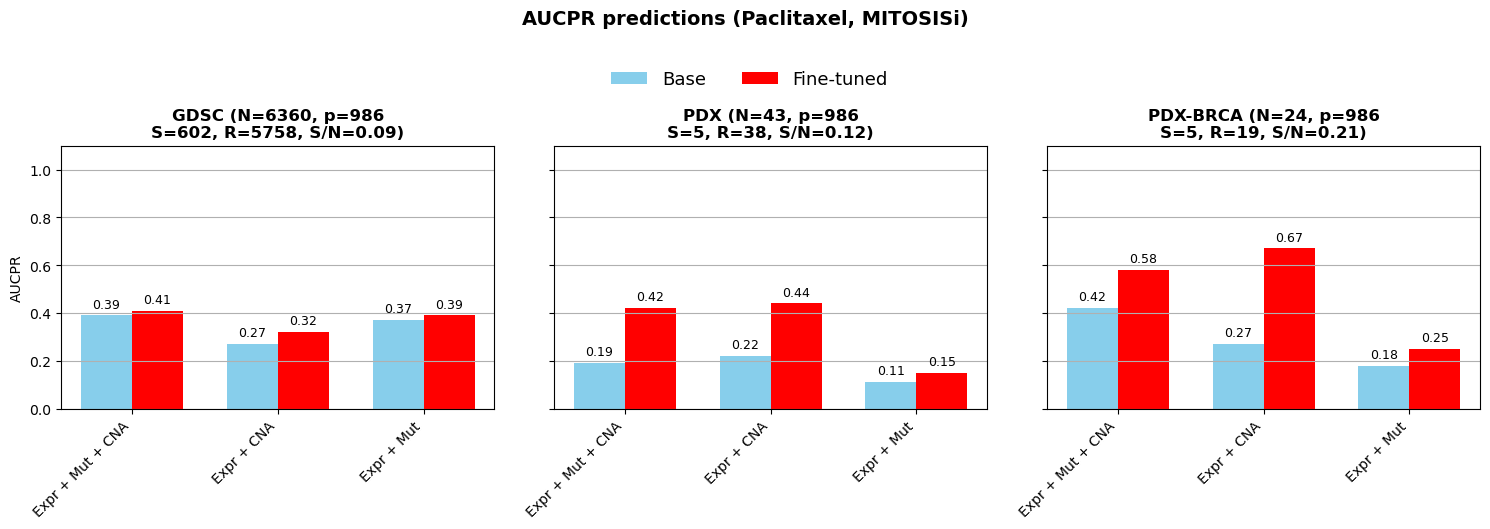

In [66]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Paclitaxel, MITOSISi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Paclitaxel, MITOSISi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [67]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_MITOSISi/Expression_CNA/Predictions


In [68]:
# save predictions

file = open('GDSC_PDX_DEGs - PDX_MITOSISi_Paclitaxel Predictions (Expression & CNA).txt', 'w')
file.write(f"GDSC Training (EC) AUC (PDX_MITOSISi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EC) AUCPR (PDX_MITOSISi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EC) AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}\n")
file.write(f"PDX Test (EC) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}\n\n")

file.close()